# Multi-GPU Programming Concepts

Welcome to the webinar _Introduction the CUDA-WARE MPI_ in Santos Dummont Summer School 2026 Program. In this webinar you will learn several techniques for scaling single GPU applications to multi-GPU and multiple nodes, with an emphasis on multi-GPU APIs: [NCCL (NVIDIA Collective Communications Library)](https://docs.nvidia.com/deeplearning/sdk/nccl-developer-guide/docs/index.html), [CUDA-WARE-MPI](https://developer.nvidia.com/blog/introduction-cuda-aware-mpi/), and [NVSHMEM](https://developer.nvidia.com/nvshmem) which allows for elegant multi-GPU application code and has been proven to scale very well on systems with many GPUs.

## The Coding Environment

The first step is display information about the CPU architecture with the command `lscpu`

In [1]:
!lscpu

Arquitetura:                x86_64
Modo(s) operacional da CPU: 32-bit, 64-bit
Ordem dos bytes:            Little Endian
CPU(s):                     48
Lista de CPU(s) on-line:    0-47
Thread(s) per núcleo:       1
Núcleo(s) por soquete:      24
Soquete(s):                 2
Nó(s) de NUMA:              2
ID de fornecedor:           GenuineIntel
Família da CPU:             6
Modelo:                     85
Nome do modelo:             Intel(R) Xeon(R) Gold 6252 CPU @ 2.10GHz
Step:                       7
CPU MHz:                    2100.000
CPU MHz máx.:               3700,0000
CPU MHz mín.:               1000,0000
BogoMIPS:                   4200.00
Virtualização:              VT-x
cache de L1d:               32K
cache de L1i:               32K
cache de L2:                1024K
cache de L3:                36608K
CPU(s) de nó0 NUMA:         0-23
CPU(s) de nó1 NUMA:         24-47
Opções:                     fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush dts 

In this node, we can observe that the multi-GPU resources connect with the NUMA nodes.

For your work today, you have access to several GPUs in the cloud. Run the following cell to see the GPUs available to you today.

In [1]:
!nvidia-smi

Mon Dec 22 14:11:37 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100-SXM2-32GB           On  |   00000000:60:00.0 Off |                    0 |
| N/A   47C    P0             47W /  300W |       1MiB /  32768MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!nvidia-smi topo -m 

	GPU0	GPU1	GPU2	GPU3	NIC0	NIC1	CPU Affinity	NUMA Affinity	GPU NUMA ID
GPU0	 X 	NV2	NV2	NV2	PIX	SYS	0-23	0		N/A
GPU1	NV2	 X 	NV2	NV2	PIX	SYS	0-23	0		N/A
GPU2	NV2	NV2	 X 	NV2	SYS	PIX	24-47	1		N/A
GPU3	NV2	NV2	NV2	 X 	SYS	PIX	24-47	1		N/A
NIC0	PIX	PIX	SYS	SYS	 X 	SYS				
NIC1	SYS	SYS	PIX	PIX	SYS	 X 				

Legend:

  X    = Self
  SYS  = Connection traversing PCIe as well as the SMP interconnect between NUMA nodes (e.g., QPI/UPI)
  NODE = Connection traversing PCIe as well as the interconnect between PCIe Host Bridges within a NUMA node
  PHB  = Connection traversing PCIe as well as a PCIe Host Bridge (typically the CPU)
  PXB  = Connection traversing multiple PCIe bridges (without traversing the PCIe Host Bridge)
  PIX  = Connection traversing at most a single PCIe bridge
  NV#  = Connection traversing a bonded set of # NVLinks

NIC Legend:

  NIC0: mlx5_0
  NIC1: mlx5_1



While your work today will be on a single node, all the techniques you learn today, in particular CUDA-WARE-MPI and NVSHMEM, can be used to run your applications across clusters of multi-GPU nodes.

Let us show the NVLink Status for different GPUs reported from `nvidia-smi`:

In [3]:
!nvidia-smi nvlink --status -i 0

GPU 0: Tesla V100-SXM2-32GB (UUID: GPU-3c03cbb9-3dbf-10a2-db75-da50a18314a9)
	 Link 0: 25.781 GB/s
	 Link 1: 25.781 GB/s
	 Link 2: 25.781 GB/s
	 Link 3: 25.781 GB/s
	 Link 4: 25.781 GB/s
	 Link 5: 25.781 GB/s


In the end, it gives information about the NUMA memory nodes, with tue `lstopo` command, that is used to show the topology of the system.  

In [4]:
!lstopo --of png > sdumont.png

This will import and display a .png image in Jupyter:

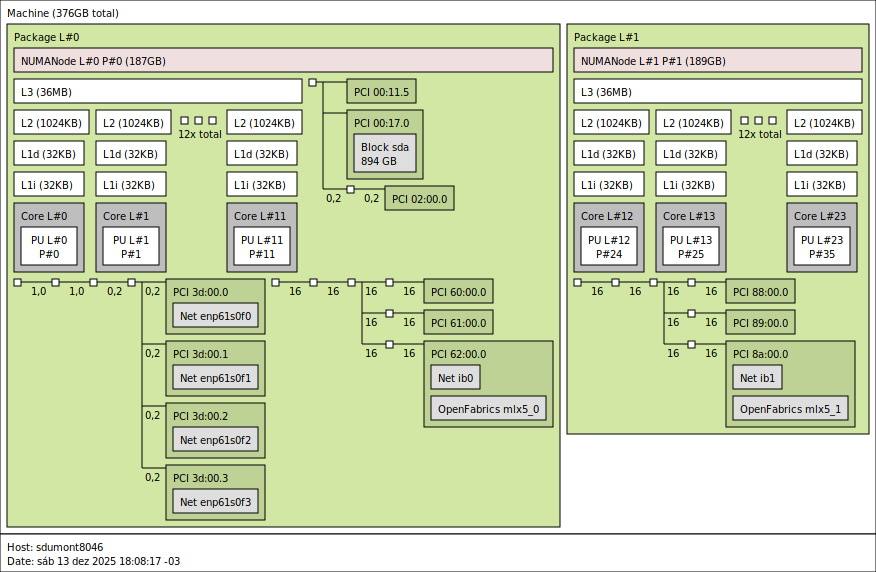

In [5]:
from IPython.display import display
from PIL import Image
path="sdumont.png"
display(Image.open(path))

## Environment Modules on SDumont

### SLURM Script for Jupyter-lab:

```cpp
#!/bin/bash
#SBATCH --ntasks=1
#SBATCH --gpus=4
#SBATCH --gpus-per-node=4
#SBATCH --time 00:20:00
#SBATCH --partition=sequana_gpu_dev
#SBATCH --job-name jupyter-notebook
#SBATCH --output jupyter-notebook-%J.log

# get tunneling info
XDG_RUNTIME_DIR=""
node=$(hostname -s)
user=$(whoami)
port=65100

# module load <packages> 
module load anaconda3/2024.02_sequana
module load nccl/2.13_cuda-11.2
module load openmpi/gnu/4.1.4+cuda-11.2_sequana
module load nvshmem/3.1.7_cuda-11.2_sequana

#ativar o virtual env
source activate $SCRATCH/conda-env/jupyter

#acessar o diretorio do notebook
#cd $SCRATCH/my-notebook
cd /scratch/treinamento/murilo.boratto2/GPU-programming/supercomputers/SDumont/

# Executar o Jupyter
jupyter notebook --no-browser --port=${port} --ip=0.0.0.0
```

### Loaded Modulefiles:

These modules must be initialized before running the jupyter-notebook:
```cpp
Currently Loaded Modulefiles:
    1)  xpmem/2.7.4_gcc-12.4_sequana                
    2)  cuda/11.2_sequana                        
    3)  ucx/1.17_gcc-12.4+cuda-12.6_sequana  
    4)  hwloc/2.11.2_gcc-12.4_sequana
    5)  libevent/2.1.12_gcc-12.4_sequana
    6)  gcc/12.4.0_sequana 
    7)  libltdl/2.5.3_gcc-12.4_sequana
    8)  openpmix/4.2.8_sequana
    9)  openmpi/gnu/4.1.4+cuda-11.2_sequana
    10) anaconda3/2024.02_sequana 
    11) nccl/2.13_cuda-11.2
    12) nvshmem/3.1.7_cuda-11.2_sequana
```

## Table of Contents

During this short course today you will work through each of the following notebooks:

- [_NCCL_](2-MC-SD03-II-SDumont-NCCL-P2P.ipynb): In this notebook you will introduced the NCCL API, and the concepts of peer-to-peer communication between GPUs.

- [_CUDA-WARE-MPI_](3-MC-SD03-II-SDumont-CUDAWARE-MPI.ipynb): You will begin by familiarizing with the concepts of CUDA-WARE-MPI API to multi-GPU nodes.

- [_Monte Carlo Approximation of $\pi$ - Single GPU_](4-MC-SD03-II-SDumont-MCπ-SGPU.ipynb): You will begin by familiarizing yourself with a single GPU implementation of the monte-carlo approximation of π algorithm, which we will use to introduce many multi GPU programming paradigms.

- [_Monte Carlo Approximation of $\pi$ - Multiple GPUs_](5-MC-SD03-II-SDumont-MCπ-MGPU.ipynb): In this notebook you will extend the monte-carlo π program to run on multiple GPUs by looping over available GPU devices.

- [_Monte Carlo Approximation of $\pi$ - CUDA-WARE-MPI_](6-MC-SD03-II-SDumont-MCπ-CUDAWARE-MPI.ipynb): In this notebook you will learn how to applied the CUDA-WARE-MPI, and some concepts about peer-to-peer communication between GPUs in the SPMD paradigm.

- [_Monte Carlo Approximation of $\pi$ - NVSHMEM_](7-MC-SD03-II-SDumont-MCπ-NVSHMEM.ipynb): In this notebook you will be introduced to NVSHMEM, and will take your first pass with it using the monte-carlo π program.

- [_Jacobi Iteration_](8-MC-SD03-II-SDumont-Jacobi.ipynb): In this notebook you will be introduced to a Laplace equation solver using Jacobi iteration and will learn how to use NVSHMEM to handle boundary communications between multiple GPUs.

## Clear the Memory

Before moving on, please execute the following cell to clear up the CPU memory. This is required to move on to the next notebook.

In [ ]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

## Next

In the next section, you will see  how to learn the GPU concepts using the API NCCL [_2-SDumont-NCCL-P2P.ipynb_](2-SDumont-NCCL-P2P.ipynb)